In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, confusion_matrix
import xgboost as xgb
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 15})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Read the train dataset from the CSV file
train_set = pd.read_csv('../data/train_df_expanded_KNN_imp_feats.csv')
# Replace infinite values with NaN
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [4]:
train_set['Target > 1'] = train_set['Abs Target'].apply(lambda x: 1 if x > 1 else 0)

In [5]:
# Extract the target variable from the dataset
y_train = train_set['Target > 1']
# Drop unnecessary columns and keep the feature matrix
x_train = train_set.drop(['Date', 'Target', 'Abs Target', 'Target > 1', 'Target > 2'], axis=1)

In [6]:
# Split the data into training, validation, and test sets using a 60-20-20 split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

# Drop the first 5 rows of validation set to avoid leakage from lagged features
X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [7]:
# Define the hyperparameters for the XGBoost model
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['logloss'],
          'lambda': 1, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2}

# Train the XGBoost model
clf = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=300,verbose_eval=True,early_stopping_rounds=10)

[0]	train-logloss:0.65028	test-logloss:0.64872
[1]	train-logloss:0.61145	test-logloss:0.60838
[2]	train-logloss:0.57623	test-logloss:0.57177
[3]	train-logloss:0.54401	test-logloss:0.53834
[4]	train-logloss:0.51438	test-logloss:0.50723
[5]	train-logloss:0.48721	test-logloss:0.47840
[6]	train-logloss:0.46204	test-logloss:0.45218
[7]	train-logloss:0.43897	test-logloss:0.42792
[8]	train-logloss:0.41743	test-logloss:0.40533
[9]	train-logloss:0.39751	test-logloss:0.38452
[10]	train-logloss:0.37902	test-logloss:0.36512
[11]	train-logloss:0.36186	test-logloss:0.34731
[12]	train-logloss:0.34585	test-logloss:0.33050
[13]	train-logloss:0.33107	test-logloss:0.31500
[14]	train-logloss:0.31716	test-logloss:0.30007
[15]	train-logloss:0.30412	test-logloss:0.28613
[16]	train-logloss:0.29189	test-logloss:0.27329
[17]	train-logloss:0.28046	test-logloss:0.26110
[18]	train-logloss:0.26967	test-logloss:0.25029
[19]	train-logloss:0.25957	test-logloss:0.24004
[20]	train-logloss:0.25012	test-logloss:0.22992
[2

In [8]:
# Make predictions on training and validation data
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

In [9]:
# Feature importance analysis using 'gain' method
feat_importance = clf.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

# Feature importance analysis using 'weight' method
feat_importance = clf.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Feature importance analysis using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

# Combine the top features from each importance analysis method
top_K_feat = set(top_10_gain+top_10_weight+top_10_shap)

In [10]:
# Save dictionary of best features
with open("./clf_top_K_feat_plusMinus1.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

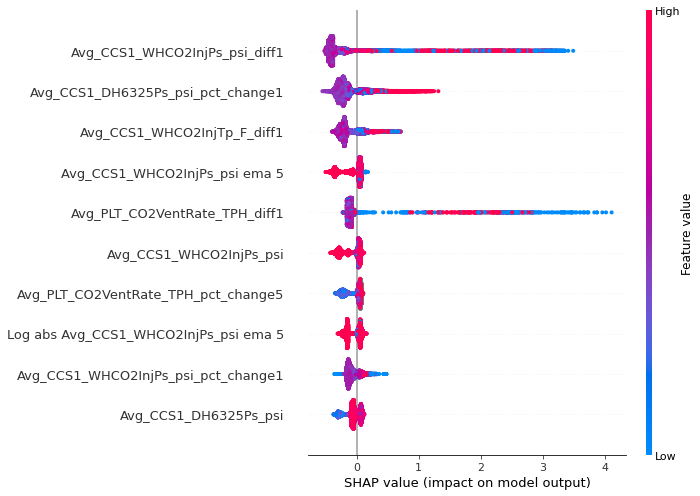

In [11]:
# Plot the SHAP summary plot for the top 10 features
shap.summary_plot(shap_values, X_train,
                   plot_size=(10, 7), max_display=10)

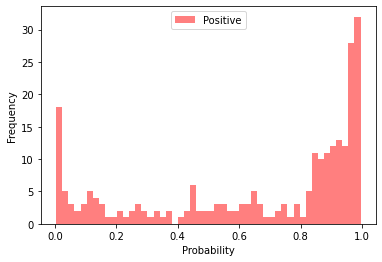

In [12]:
# plot the histogram of probabilities with the color representing the true label
plt.hist(y_pred_val[y_val==1], bins=50, color='r', alpha=0.5, label='Positive')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper center')
plt.show()

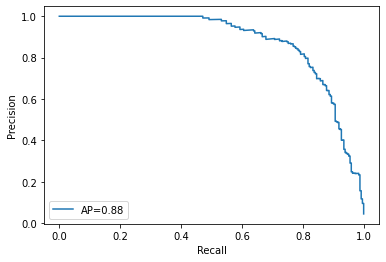

In [13]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
average_precision = average_precision_score(y_val, y_pred_val)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [14]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_val)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.3386


In [15]:
# predict binary labels using the best threshold
y_pred = (y_pred_val >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

In [16]:
cm

array([[5212,   29],
       [  57,  189]], dtype=int64)